In [ ]:
from typing import List
import cv2
import torch
from PIL import Image
import numpy as np
import sys 
import config 
import torch.nn.functional as F

REPO_PATH = "/mnt/c/Users/antonio/Desktop/dinov2"
sys.path.append(config.REPO_PATH)

from dinov2.hub.dinotxt import dinov2_vitl14_reg4_dinotxt_tet1280d20h24l, get_tokenizer
from dinov2.data.transforms import make_classification_eval_transform

class VLM_wrapper:
    def __init__(self, model, resize_size: int = 512, class_names: List[str] = None):
        """
        Initializes the model, tokenizer, and transforms.
        """
        self.device = config.DEVICE
        
        self.model = model
        self.tokenizer = get_tokenizer()

        self.image_size = resize_size 
        self.crop_size = resize_size

        self.transform = make_classification_eval_transform(resize_size=resize_size, crop_size=self.crop_size)

        self.grid_size = self.crop_size // 14

        self.class_names = []
        self.class_embeddings = torch.Tensor([]).to(self.device)

        if class_names:
            self.class_names = class_names
            self.class_embeddings = self._generate_ensemble_text_features(class_names)


    def get_transform(self):
        return self.transform    

    def set_classes_to_detect(self, class_names: List[str]):
        """
        Generates and stores text embeddings for a given list of class names.
        """
        print(f"Setting detection classes: {class_names}")
        self.class_names = class_names
        if not class_names:
            self.class_embeddings = torch.Tensor([]).to(self.device)
        else:
            self.class_embeddings = self._generate_ensemble_text_features(class_names)
        print("Class embeddings are ready.")

    def _generate_ensemble_text_features(self, class_names: List[str]) -> torch.Tensor:
        """
        Generates robust text features by averaging embeddings from multiple prompt templates.
        The feature embeddings are already normalized
        """
        templates = ["a photo of a {}", "an image of a {}", "a high quality photo of a {}", "a picture of a {}", "{}"]
        
        with torch.no_grad():
            all_text_features = []
            for class_name in class_names:
                prompts = [template.format(class_name) for template in templates]
                tokenized_prompts = self.tokenizer.tokenize(prompts).to(self.device)


                # dinotxt says that only the last part of the embedding is aligned to patches
                text_patch_features = self.model.encode_text(tokenized_prompts)[:, 1024:]

                # Average the features for the current class and normalize
                class_features = text_patch_features.mean(dim=0, keepdim=True)
                class_features = F.normalize(class_features, dim=-1)
                all_text_features.append(class_features)
                
            ensemble_features = torch.cat(all_text_features)
        return ensemble_features

    def get_similarity_scores(self, image):
        """
        Computes cosine similarity between image patches and all pre-set class embeddings.

        Args:
            image: The input image, it has to be either PIL or numpy array.

        Returns:
            A tuple containing:
            - A 3D numpy array of heatmaps (num_classes, height, width), or None.
            - The list of class names corresponding to the heatmaps.
        """
        if self.class_embeddings.nelement() == 0:
            return None, []

        image_tensor = self.transform(image).to(self.device)
        if len(image_tensor) == 3: # model require B,C,H,W
            image_tensor = image_tensor.unsqueeze(0)
        
        with torch.no_grad():
            _, patch_features = self.model.get_visual_class_and_patch_tokens(image_tensor)
            # normalization on last dimension, so the patches features are normalized
            patch_features = F.normalize(patch_features, dim=-1) # Shape: (1, num_patches, dim)

        # (1, num_patches, dim) @ (dim, num_classes) -> (1, num_patches, num_classes)
        all_similarities = patch_features @ self.class_embeddings.T
        all_similarities = all_similarities.squeeze(0) # Shape: (num_patches, num_classes)
            
        # (num_patches, num_classes) -> (num_classes, num_patches) -> (num_classes, grid_h, grid_w)
        heatmaps = all_similarities.T.reshape(len(self.class_names), self.grid_size, self.grid_size)
        
        return heatmaps, self.class_names
    

    def get_patch_tokens(self, images):
        """ 
        return [n_patches, d_embedding_size] tensor
        """
        if not isinstance(images, list):
            images = [images]

        image_tensors = [self.transform(img).to(self.device) for img in images]
        batch_tensor = torch.stack(image_tensors, dim=0) # B, nc, h, w

        with torch.no_grad():
            _, patch_features = self.model.get_visual_class_and_patch_tokens(batch_tensor)

        return patch_features
    
def create_class_map(scores: torch.Tensor,  threshold: float) -> np.ndarray:
    """
    Creates a class map with a background class based on a threshold.

    A patch is assigned to the background if its highest score across all classes
    is below the threshold. Otherwise, it's assigned to the class with the highest score.

    Args:
        scores (torch.Tensor): A tensor of shape (num_classes, H, W) containing similarity scores.
        classes (List[str]): List of class names.
        threshold (float): The minimum score for a patch to be considered foreground.

    Returns:
        np.ndarray: A 2D array of shape (H, W) where each value is the index
                    of the class with the highest score, or -1 for the background.
    """
    # Find the max score and the corresponding class index for each patch
    max_scores, class_indices = torch.max(scores, dim=0)

    # Create a boolean mask for pixels that should be considered background
    background_mask = max_scores < threshold

    # Set the class index to -1 for all pixels identified as background
    class_indices[background_mask] = -1

    return class_indices.cpu().numpy()


def batch_pca(tensor: torch.Tensor, k: int = 3, is_global: bool = False) -> torch.Tensor:
    """
    Performs PCA on a batched tensor using SVD
    Can operate in two modes:
    1. Independent (is_global=False): PCA is applied to each batch item.
    2. Global (is_global=True): The batch is treated as a single dataset.

    Args:
        tensor (torch.Tensor): The input tensor of shape [B, N, D].
        k (int): The number of principal components to keep.
        is_global (bool): Toggles between independent and global mode.

    Returns:
        torch.Tensor: The transformed tensor of shape [B, N, k].
    """
    B, N, D = tensor.shape
    if k > D:
        raise ValueError(f"k ({k}) cannot be greater than the feature dimension D ({D})")

    # --- 1. Prepare Data and Parameters ---
    # Set up the data shape and parameters based on the mode.
    # This avoids repeating logic later.
    if is_global:
        # Flatten the batch for a single, global analysis
        data = tensor.reshape(B * N, D)
        mean_dim = 0
    else:
        # Use the tensor as is for independent, batched analysis
        data = tensor
        mean_dim = 1

    # --- 2. Core PCA Logic (Identical for Both Modes) ---
    # Center the data. `data` is either [B*N, D] or [B, N, D].
    mean = data.mean(dim=mean_dim, keepdim=True)
    centered_data = data - mean

    # Perform SVD. `torch.linalg.svd` handles both 2D and 3D (batched) tensors perfectly.
    _, _, Vh = torch.linalg.svd(centered_data, full_matrices=False)

    # --- 3. Extract Components and Project ---
    # The component extraction and projection logic differs slightly.
    if is_global:
        # Vh is [D, D]. Get top k components and transpose to [D, k]
        components = Vh[:k, :].T
        # Project the global data: [B*N, D] @ [D, k] -> [B*N, k]
        projected = centered_data @ components
        # Reshape back to batched format
        projected = projected.reshape(B, N, k)
    else:
        # Vh is [B, D, D]. Get top k components for each item.
        # Vh[:, :k, :] -> [B, k, D]. Transpose to [B, D, k]
        components = Vh[:, :k, :].transpose(-1, -2)
        # Batched projection: [B, N, D] @ [B, D, k] -> [B, N, k]
        projected = centered_data @ components

    return projected


In [2]:
model = dinov2_vitl14_reg4_dinotxt_tet1280d20h24l().to('cuda').eval()

/mnt/c/Users/antonio/Desktop/dinov2/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/mnt/c/Users/antonio/Desktop/dinov2/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/mnt/c/Users/antonio/Desktop/dinov2/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [64]:
NUM_PATCHES = 64
vlm = VLM_wrapper(model, resize_size=NUM_PATCHES*14)

Setting detection classes: ['dogs', 'chair', 'bowl', 'wooden floor', 'desk']
Class embeddings are ready.
torch.Size([1, 16384, 1024])


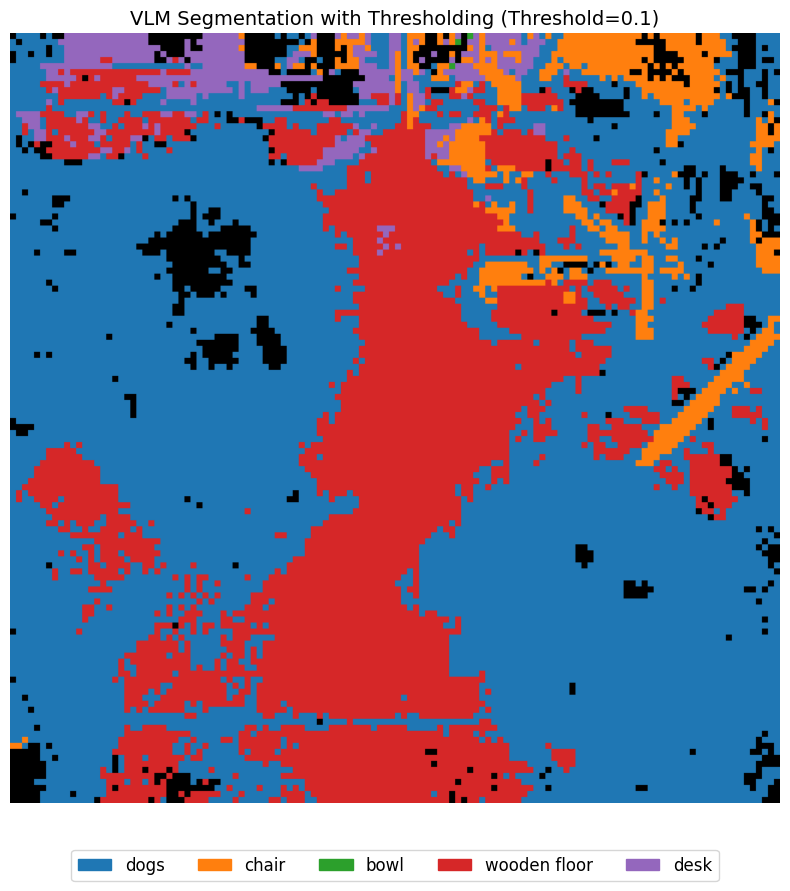

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import urllib

transform = vlm.get_transform()
img = Image.open(f"{REPO_PATH}/picture5.jpg").convert("RGB")

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
img = load_image_from_url(EXAMPLE_IMAGE_URL)

classes_to_detect = ['dogs', 'chair', 'bowl', 'wooden floor', 'desk']
vlm.set_classes_to_detect(classes_to_detect)
scores, classes = vlm.get_similarity_scores(img)


SCORE_THRESHOLD = 0.01
class_map_indices = create_class_map(scores, threshold=SCORE_THRESHOLD)

num_classes = len(classes_to_detect)
cmap = plt.get_cmap('tab10' if num_classes <= 10 else 'tab20')
COLORS = [cmap(i)[:3] for i in range(num_classes)] # [(R,G,B); (R,G,B) ...]


BG_COLOR = [0.0, 0.0, 0.0]  
color_palette = np.array(COLORS + [BG_COLOR]) # concatenate black at the end
color_mask = color_palette[class_map_indices] # (64,64,3)

# Image cropped as the model demands it, minus IMAGENET normalizaiton
image_for_viz = make_classification_eval_transform(resize_size=NUM_PATCHES*14, crop_size=NUM_PATCHES*14, mean=[0,0,0], std=[1,1,1])(img)
image_for_viz = image_for_viz.permute(1, 2, 0).numpy() # C,H,W -> H,W,C
image_for_viz = np.clip(image_for_viz, 0, 1)

# Upscale the low-resolution color mask to match the image size
upscaled_mask = cv2.resize(
    color_mask.astype(np.float32),
    (vlm.crop_size, vlm.crop_size),
    interpolation=cv2.INTER_NEAREST 
)

# Blend the image with the upscaled color mask
alpha = 0.5  
blended_image = (1 - alpha) * image_for_viz + alpha * upscaled_mask

# Display the final image with a legend
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(blended_image)
ax.axis('off')

# Create a legend that maps colors to class names (excluding the background)
legend_patches = [
    Patch(color=color, label=class_name)
    for class_name, color in zip(classes_to_detect, COLORS)
]

ax.legend(
    handles=legend_patches,
    bbox_to_anchor=(0.5, -0.05),
    loc='upper center',
    ncol=len(classes_to_detect),
    fontsize=12
)
plt.title(f"VLM Segmentation with Thresholding (Threshold={SCORE_THRESHOLD})", fontsize=14)
plt.show()

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load images
img1 = Image.open(f"{REPO_PATH}/picture.jpg").convert("RGB")
img2 = Image.open(f"{REPO_PATH}/picture2.jpg").convert("RGB")
images = [img1, img2]



# Get patch tokens and apply PCA
raw = vlm.get_patch_tokens(images)  # shape: [B, N_patches, D]
pca = batch_pca(raw, 3,is_global=True)  # shape: [B, N_patches, 3]

B, _, _ = pca.shape
pca_map = pca.reshape(B, NUM_PATCHES, NUM_PATCHES, 3).cpu().numpy()
pca_map = np.clip(pca_map, 0, 1)
print(pca_map.shape)
pca_map = [
    [0,0,0] if img[0,:,:] < 0.1 else img for img in pca_map
]

# Resize PCA maps to match crop size
upscaled_masks = [
    cv2.resize(pca_map[i].astype(np.float32), (vlm.crop_size, vlm.crop_size), interpolation=cv2.INTER_NEAREST)
    for i in range(B)
]

images = [make_classification_eval_transform(resize_size=NUM_PATCHES*14, crop_size=NUM_PATCHES*14, mean=[0,0,0], std=[1,1,1])(img).permute(1,2,0) for img in images]


# Plot: original images on top, PCA maps on bottom
fig, axes = plt.subplots(2, B, figsize=(5 * B, 10))

if B == 1:
    axes = np.expand_dims(axes, axis=1)  # ensure 2x1 layout for single image

for i in range(B):
    # Original image
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')


    # PCA map
    axes[1, i].imshow(upscaled_masks[i])
    axes[1, i].axis('off')


plt.tight_layout()
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()